In [2]:
# Import the necessary dependencies

# Operating System
import os

# Numpy, Pandas and Scipy
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, save_npz, load_npz

# Scikit-learn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# Model Evaluation
from evaluation import evaluate

# Submtion Evaluation
from validate_sample_submission import validate_submission

# 1: Import and exploratory analysis

#### BOOK RATING

In [3]:
#reading and analising book rating information

bookratings = pd.read_csv('data/BookRatings.csv')
print(bookratings.shape)
bookratings.head()

bookratings['Book-Rating'].value_counts(dropna=False) #from 1 to 10 and no missing values

bookratings['User-ID'].nunique() #5719
bookratings_users = bookratings['User-ID'].unique()

bookratings['ISBN'].nunique() #47768

bookratings[['User-ID','ISBN']].drop_duplicates() #there are no duplicates - 109209 rows × 2 columns

bookratings.head()

(109209, 3)


,User-ID,ISBN,Book-Rating
0,99,0316748641,7
1,99,0446677450,10
2,99,0553347594,9
3,99,0451166892,3
4,99,0671621009,10


#### TEST USERS

In [4]:
#reading and analising test users table

test_users = pd.read_csv('data/test_users.csv')
print(test_users.shape)

test_users['User-ID'].nunique() #there are no duplicates
test_users.head()

(589, 1)


,User-ID
0,114
1,507
2,850
3,3346
4,4092


In [5]:
# counting users that are already client and new prospects
test_users.isin(bookratings_users).sum(axis=0) #489

# list of clients with rating information
test_users_clients = test_users[test_users.isin(bookratings_users)].dropna() #489

# list of new prospects
test_users_new = test_users[~test_users.isin(bookratings_users)].dropna() #100


#### BOOKS META INFO

In [6]:
booksmetainfo = pd.read_csv('data/BooksMetaInfo.csv')

booksmetainfo.shape #(112341, 12)
booksmetainfo.head(1)

/home/fernandamcohen/.virtualenvs/blu12/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,authors,description,pageCount,categories
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,"['Mark P. O. Morford', 'Robert J. Lenardon']",Provides an introduction to classical myths pl...,808.0,['Social Science']


#### BOOKS USERS

,User-ID,Location,Age
0,2,"stockton, california, usa",18.0
1,8,"timmins, ontario, canada",NaN


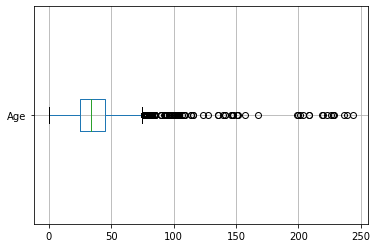

In [7]:
booksusers = pd.read_csv('data/BooksUsers.csv')
booksusers.shape #(61568, 3)

# booksusers['Age'].plot.hist(bins=20)
#NaN      24605

pd.DataFrame(booksusers.Age).boxplot(vert=False);

booksusers.head(2)


# 2: Non-personalised recommendation

In [13]:
def make_ratings(data):
    """Creates the ratings matrix of listening history with optional shape
    
    Creates the ratings matrix from the listening history imported using the read_users_history() method.
    
    Args:
        data (pd.DataFrame):  Listening history for the users.
        shape (tuple): The overall (n_users, n_items) shape desired for the matrix. 
                       If None, define the shape with the (n_users, n_items) from data argument.
        
    Returns:
        ratings (csr_matrix): Ratings matrix with shape (n_users, n_items).
    
    """
    users, user_pos = np.unique(data.iloc[:, 0].values, return_inverse=True)
    items, item_pos = np.unique(data.iloc[:, 1].values, return_inverse=True)
    values = data.iloc[:, 2].fillna(0).values
    
    #R Matrix dimensions (n_users, n_items)
    shape = (len(users), len(items))

    R_ = csr_matrix((values, (user_pos, item_pos)), shape=shape)
    return R_



def make_train_val_split(data, test_size = 0.2):
    """Split the data into train and validation and returns the ratings matrixes accordingly.
    
    Args:
        data (pd.DataFrame): Listening history for the users.
        test_size (float): Percentage of listening history used for validation.
    
    Returns:
        ratings_train (csr_matrix): Ratings matrix for train.
        ratings_val (csr_matrix): Ratings matrix for validation.
    
    """
    train_data, val_data = train_test_split(data, test_size=test_size, random_state=8)

    #Store the indexes of each observation to identify which records to replace with zero
    train_index = train_data.index
    val_index = val_data.index

    #make copies of data to replace the observations
    train_data_clean = data.copy()
    val_data_clean = data.copy()

    #Replace the validation observations on the training data
    train_data_clean.loc[val_index,["Book-Rating"]] = 0
    
    #Replace the training observations on the validation data
    val_data_clean.loc[train_index,["Book-Rating"]] = 0

    #Create the R matrices
    R_train = make_ratings(train_data_clean)
    R_val = make_ratings(val_data_clean)

    #remove the explicit zeros from the sparse matrices
    R_train.eliminate_zeros()
    R_val.eliminate_zeros()

    return R_train, R_val


In [14]:
#creating traning and validation sets

test_size = 0.2

ratings_train, ratings_val = make_train_val_split(bookratings, test_size=test_size)

ratings_train.shape #(5719, 47768)
ratings_val.shape #(5719, 47768)

ratings_train.nnz #87367
ratings_val.nnz #21842

21842

In [151]:
ratings_train[ratings_train>0].mean(axis=0).shape
# .plot.hist(bins=20)

(1, 87367)

In [ ]:
pd.DataFrame(data).pivot(index=0, columns=1, values=2).head(5)

def remove_zeros(R):
    R_ = R.copy()
    R_[R_ == 0] = np.NaN
    
    return R_

# ratings_train_ = remove_zeros(ratings_train)

/home/fernandamcohen/.virtualenvs/blu12/lib/python3.6/site-packages/ipykernel_launcher.py:7: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  import sys
/home/fernandamcohen/.virtualenvs/blu12/lib/python3.6/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [12]:
np.nanmean(ratings_train, axis=0)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all().